In [49]:
import snap
import re

# ENCRYPT COZ POST ID CAN ONLY BE INT

def convert_to_integer(post_id):
    base = 36  # 10 digits + 26 letters

    # Remove leading and trailing single quotes if present
    post_id = post_id.strip("'")

    # Convert each character to its corresponding integer value
    int_values = [int(c, base) for c in post_id]

    # Combine the integer values to get a unique integer for the whole string
    result = 0
    for value in int_values:
        result = result * base + value

    return result

# Create a graph
G = snap.TNEANet.New()

# Read data from file
with open('formatted_data_file.txt', 'r') as file:
    data = file.read()

# Split the data into lines
lines = data.strip().split('\n')

# Mapping between community names and their node IDs
community_to_id = {}

# Add nodes and edges to the graph
for line in lines:
    # Split the line using either tab or space as the separator
    parts = re.split(r'\t|\s+', line)  

    # Extract values into variables
    source_community = parts[0]
    target_community = parts[1]
    post_id_source = parts[2]
    timestamp_source = parts[3] + " " + parts[4]  # Combine date and time
    user = parts[5]
    post_id_target = parts[6]
    timestamp_target = parts[7] + " " + parts[8]  # Combine date and time

    # Add nodes if they don't exist
    if source_community not in community_to_id:
        source_community_id = G.AddNode()
        community_to_id[source_community] = source_community_id

    if target_community not in community_to_id:
        target_community_id = G.AddNode()
        community_to_id[target_community] = target_community_id

    # Convert alphanumeric post IDs to integers
    post_id_source_int = convert_to_integer(post_id_source)
    post_id_target_int = convert_to_integer(post_id_target)

    # Add edge
    edge_id = G.AddEdge(source_community_id, target_community_id)

    # Add attributes for source and target post IDs
    G.AddIntAttrDatE(edge_id, post_id_source_int, "source_post_id")
    G.AddIntAttrDatE(edge_id, post_id_target_int, "target_post_id")
    



# Print the total number of nodes and edges
print("Total Nodes:", G.GetNodes())
print("Total Edges:", G.GetEdges())


Total Nodes: 35776
Total Edges: 286561


In [50]:
# Read label info from file and convert to a dictionary
with open('label_info.tsv', 'r') as label_file:
    label_lines = label_file.read().strip().split('\n')

# Convert label lines to a dictionary
sentiment_dict = {}
for label_line in label_lines:
    parts = label_line.split()
    if len(parts) == 3:
        post_id_from, post_id_to, sentiment = parts[0][1:-1], parts[1][:-1], parts[2]
        post_id_from_int = convert_to_integer(post_id_from)
        post_id_to_int = convert_to_integer(post_id_to)
        sentiment_dict[(post_id_from_int, post_id_to_int)] = sentiment

# Add sentiment attribute to edges
for edge in G.Edges():
    source_post_id = G.GetIntAttrDatE(edge.GetId(), "source_post_id")
    target_post_id = G.GetIntAttrDatE(edge.GetId(), "target_post_id")
    
    # Check if the post ID pair is present in the sentiment dictionary
    if (source_post_id, target_post_id) in sentiment_dict:
        sentiment_value = 1 if sentiment_dict[(source_post_id, target_post_id)] == 'burst' else 0 
        G.AddIntAttrDatE(edge.GetId(), sentiment_value, "sentiment")

Total Number of Edges with Negative Sentiment: 16608
Correlation Coefficient: -0.0571646992463337
P-value: 2.740326011169841e-27


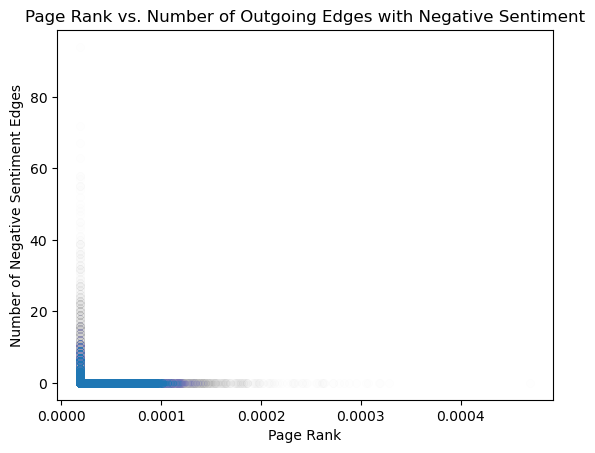

In [108]:
import matplotlib.pyplot as plt

# Count the number of edges with negative sentiment
total_negative_edges = 0

for edge in G.Edges():
    edge_id = edge.GetId()
    try:
        sentiment = G.GetIntAttrDatE(edge_id, "sentiment")
        if sentiment == 1:  # Assuming 1 corresponds to negative sentiment
            total_negative_edges += 1
    except RuntimeError:
        # No sentiment attribute found for this edge
        pass

print(f"Total Number of Edges with Negative Sentiment: {total_negative_edges}")


# Calculate PageRank
PRankH = snap.TIntFltH()
snap.GetPageRank(G, PRankH)

subreddit_percentages = {}
# Collect data for visualization
node_ids = []
page_ranks = []
num_negative_sentiments = []

for node in G.Nodes():
    node_id = node.GetId()
    subreddit_id = node.GetId()

    # Get PageRank
    page_rank = PRankH[node_id]
    
    # Initialize counter for outgoing negative sentiments
    num_negative_edges = 0

    # Iterate over outgoing edges
    for out_edge in node.GetOutEdges():
        try:
            sentiment = G.GetIntAttrDatE(G.GetEId(node_id, out_edge), "sentiment")
            #sentiment = G.GetIntAttrDatE(G.GetEId(subreddit_id, out_edge), "sentiment")
            if sentiment == 1:  # Assuming 1 corresponds to negative sentiment
                num_negative_edges += 1
        except RuntimeError:
            # No sentiment attribute found for this edge
            pass
        
    # Calculate percentage of negative sentiment edges
    if total_edges > 0:
        percentage_negative = (num_negative_edges / total_negative_edges) * 100
        
        subreddit_percentages[node_id] = percentage_negative

    node_ids.append(node_id)
    page_ranks.append(page_rank)
    num_negative_sentiments.append(num_negative_edges)


# Calculate correlation coefficient
correlation_coefficient, p_value = stats.pearsonr(page_ranks, num_negative_sentiments)
print(f'Correlation Coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

# Plotting
plt.scatter(page_ranks, num_negative_sentiments, alpha=0.005)
plt.title('Page Rank vs. Number of Outgoing Edges with Negative Sentiment')
plt.xlabel('Page Rank')
plt.ylabel('Number of Negative Sentiment Edges')
plt.show()

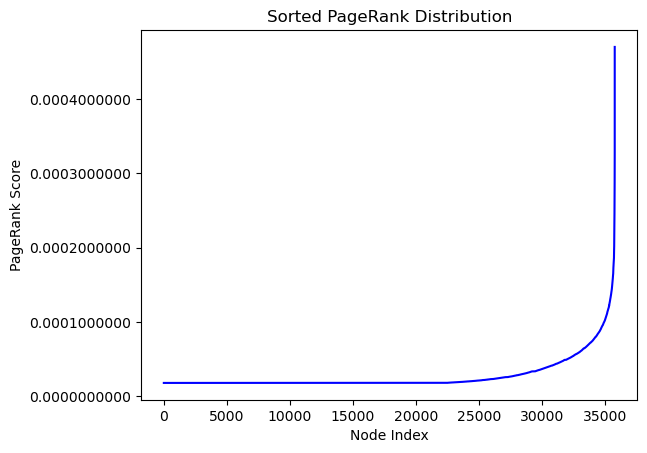

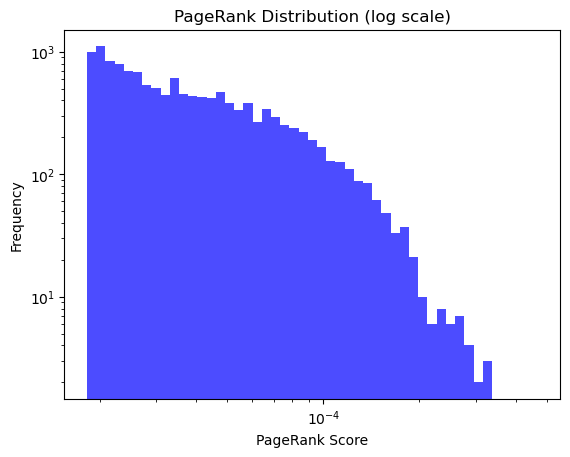

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate PageRank
PRankH = snap.TIntFltH()
snap.GetPageRank(G, PRankH)

# Collect PageRank values for all nodes
page_ranks = [PRankH[node.GetId()] for node in G.Nodes()]

# Plotting the histogram on a logarithmic scale
plt.hist(page_ranks, bins=np.logspace(np.log10(min(page_ranks)), np.log10(max(page_ranks)), 50), log=True, color='blue', alpha=0.7)
plt.xscale('log')
plt.title('PageRank Distribution (log scale)')
plt.xlabel('PageRank Score')
plt.ylabel('Frequency')
plt.show()


Node 0: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 1: Page Rank 3.368789325947709e-05, Outgoing Negative Sentiments 0
Node 2: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 3: Page Rank 3.368789325947709e-05, Outgoing Negative Sentiments 0
Node 4: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 5: Page Rank 3.368789325947709e-05, Outgoing Negative Sentiments 0
Node 6: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 7: Page Rank 3.368789325947709e-05, Outgoing Negative Sentiments 0
Node 8: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 9: Page Rank 3.368789325947709e-05, Outgoing Negative Sentiments 0
Node 10: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 11: Page Rank 3.368789325947709e-05, Outgoing Negative Sentiments 0
Node 12: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 13: Page Rank 3.368789325947709e-05, Outgoing Negative Sentimen

Node 20839: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 20840: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 20841: Page Rank 0.00014719060898774194, Outgoing Negative Sentiments 0
Node 20842: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 20843: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 20844: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 20845: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 20846: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 20847: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 20848: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 20849: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 20850: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 20851: Page Rank 1.8468210923187038e-05, Outgoing Negative Sentiments 0
Node 20852: Page Rank

Node 32834: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 32835: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 6
Node 32836: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 32837: Page Rank 4.228658384495171e-05, Outgoing Negative Sentiments 0
Node 32838: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 32839: Page Rank 4.572606007914155e-05, Outgoing Negative Sentiments 0
Node 32840: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 32841: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 32842: Page Rank 0.00014086641075068308, Outgoing Negative Sentiments 0
Node 32843: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 32844: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 32845: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 0
Node 32846: Page Rank 1.82102502056228e-05, Outgoing Negative Sentiments 2
Node 32847: Page Rank

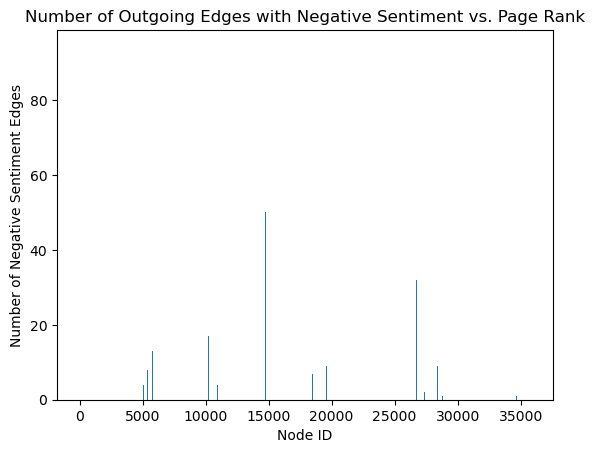

In [54]:
import matplotlib.pyplot as plt

# Calculate PageRank
PRankH = snap.TIntFltH()
snap.GetPageRank(G, PRankH)

# Collect data for visualization
node_ids = []
page_ranks = []
num_negative_sentiments = []

for node in G.Nodes():
    node_id = node.GetId()

    # Get PageRank
    page_rank = PRankH[node_id]
    
    # Initialize counter for outgoing negative sentiments
    num_negative_edges = 0

    # Iterate over outgoing edges
    for out_edge in node.GetOutEdges():
        try:
            sentiment = G.GetIntAttrDatE(G.GetEId(node_id, out_edge), "sentiment")
            if sentiment == 1:  # Assuming 1 corresponds to negative sentiment
                num_negative_edges += 1
        except RuntimeError:
            # No sentiment attribute found for this edge
            pass

    node_ids.append(node_id)
    page_ranks.append(page_rank)
    num_negative_sentiments.append(num_negative_edges)

    # Print details for each node
    print(f"Node {node_id}: Page Rank {page_rank}, Outgoing Negative Sentiments {num_negative_edges}")

# Plotting a bar plot
plt.bar(node_ids, num_negative_sentiments)
plt.title('Number of Outgoing Edges with Negative Sentiment vs. Page Rank')
plt.xlabel('Node ID')
plt.ylabel('Number of Negative Sentiment Edges')
plt.show()


In [80]:
import snap
import math

# Calculate Edge Betweenness
NIdBtwH, EdgeBtwH = snap.GetBetweennessCentr(G, 1.0, False)

# Dictionaries to store edge betweenness values for negative and non-negative sentiments
negative_sentiments = {}
non_negative_sentiments = {}
sentiments = []
betweenness = []

# Iterate over edges
for edge in G.Edges():
    edge_id = edge.GetId()

    # Get Edge Betweenness
    src, dst = edge.GetSrcNId(), edge.GetDstNId()
    key1 = snap.TIntPr(src, dst)  # Create a TIntPr (pair) object
    key2 = snap.TIntPr(dst, src)  # Create the reverse order TIntPr (pair) object

    # Check if the key exists in the hash table
    if EdgeBtwH.IsKey(key1):
        edge_betw = EdgeBtwH.GetDat(key1)
    elif EdgeBtwH.IsKey(key2):
        edge_betw = EdgeBtwH.GetDat(key2)
    else:
        # If neither key is found, skip this edge
        print(f"Edge {edge_id}: Neither key {key1} nor {key2} found in EdgeBtwH")
        continue

    # Retrieve the sentiment attribute for the edge
    try:
        sentiment = G.GetIntAttrDatE(edge_id, "sentiment")
    except RuntimeError:
        # No sentiment attribute found for this edge
        sentiment = 0
    
    sentiments.append(sentiment)
    betweenness.append(edge_betw)

    # Update the dictionaries based on sentiment
    if sentiment == 1:
        negative_sentiments[edge_id] = edge_betw
    else:
        non_negative_sentiments[edge_id] = edge_betw

# Filter out nan and inf values
negative_sentiments_values = [value for value in negative_sentiments.values() if not math.isnan(value) and not math.isinf(value)]
non_negative_sentiments_values = [value for value in non_negative_sentiments.values() if not math.isnan(value) and not math.isinf(value)]

# Calculate average edge betweenness for edges with negative sentiment
avg_edge_betweenness_negative = sum(negative_sentiments_values) / len(negative_sentiments_values) if negative_sentiments_values else 0

# Calculate average edge betweenness for edges without negative sentiment
avg_edge_betweenness_non_negative = sum(non_negative_sentiments_values) / len(non_negative_sentiments_values) if non_negative_sentiments_values else 0

print(f"Average Edge Betweenness for Edges with Negative Sentiment: {avg_edge_betweenness_negative}")
print(f"Average Edge Betweenness for Edges without Negative Sentiment: {avg_edge_betweenness_non_negative}")


Average Edge Betweenness for Edges with Negative Sentiment: 2.624171218548737e+30
Average Edge Betweenness for Edges without Negative Sentiment: -1.6702587708677346e+27


Correlation Coefficient: 8.611728039847224e-06
P-value: 0.9965299675201671


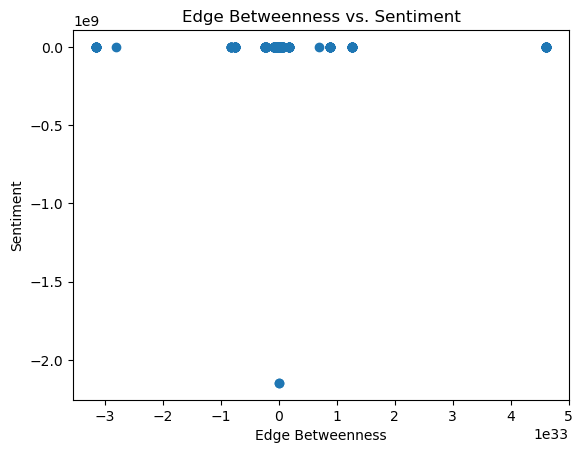

In [89]:
import snap
import math
from scipy import stats
import matplotlib.pyplot as plt

# Assuming G, NIdBtwH, and EdgeBtwH are already defined

# Dictionaries to store edge betweenness values for negative and non-negative sentiments
negative_sentiments = {}
non_negative_sentiments = {}
sentiments = []
betweenness = []

# Iterate over edges
for edge in G.Edges():
    edge_id = edge.GetId()

    # Get Edge Betweenness
    src, dst = edge.GetSrcNId(), edge.GetDstNId()
    key1 = snap.TIntPr(src, dst)  # Create a TIntPr (pair) object
    key2 = snap.TIntPr(dst, src)  # Create the reverse order TIntPr (pair) object

    # Check if the key exists in the hash table
    if EdgeBtwH.IsKey(key1):
        edge_betw = EdgeBtwH.GetDat(key1)
    elif EdgeBtwH.IsKey(key2):
        edge_betw = EdgeBtwH.GetDat(key2)
    else:
        # If neither key is found, skip this edge
        print(f"Edge {edge_id}: Neither key {key1} nor {key2} found in EdgeBtwH")
        continue

    # Retrieve the sentiment attribute for the edge
    try:
        sentiment = G.GetIntAttrDatE(edge_id, "sentiment")
    except RuntimeError:
        # No sentiment attribute found for this edge
        sentiment = 0
    
    sentiments.append(sentiment)
    betweenness.append(edge_betw)

    # Update the dictionaries based on sentiment
    if sentiment == 1:
        negative_sentiments[edge_id] = edge_betw
    else:
        non_negative_sentiments[edge_id] = edge_betw

# Filter out nan and inf values
filtered_betweenness_sentiments = [(value, sentiment) for value, sentiment in zip(betweenness, sentiments) if not math.isnan(value) and not math.isinf(value)]

# Unpack the filtered values
filtered_betweenness, filtered_sentiments = zip(*filtered_betweenness_sentiments)

# Calculate correlation coefficient
correlation_coefficient, p_value = stats.pearsonr(filtered_betweenness, filtered_sentiments)
print(f'Correlation Coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

# 5. Plotting

# Scatter plot of edge betweenness vs. sentiment
plt.scatter(filtered_betweenness, filtered_sentiments)
plt.xlabel('Edge Betweenness')
plt.ylabel('Sentiment')
plt.title('Edge Betweenness vs. Sentiment')
plt.show()


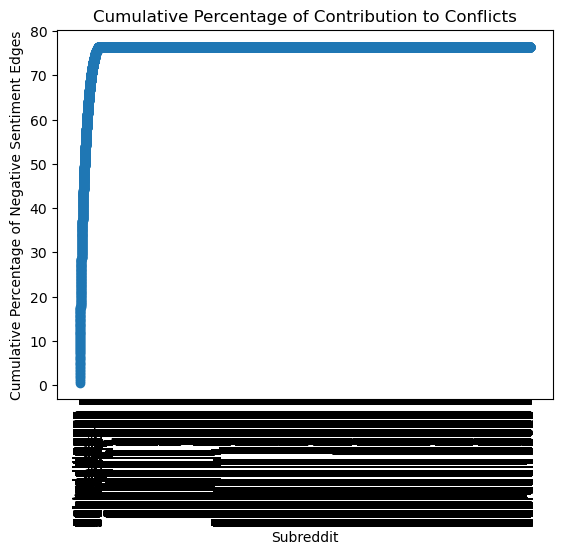

In [111]:
# Sort subreddits by percentage in descending order
sorted_subreddits = sorted(subreddit_percentages.items(), key=lambda x: x[1], reverse=True)

# Calculate cumulative percentage
cumulative_percentage = 0
top_subreddits = []
cumulative_percentages = []
print("iterating")
for subreddit, percentage in sorted_subreddits:
    cumulative_percentage += percentage
    top_subreddits.append((subreddit, percentage))
    cumulative_percentages.append(cumulative_percentage)
    
print("")
# Visualize the cumulative percentage
plt.plot([f"Subreddit {subreddit}" for subreddit, _ in top_subreddits], cumulative_percentages, marker='o')
plt.xlabel('Subreddit')
plt.ylabel('Cumulative Percentage of Negative Sentiment Edges')
plt.title('Cumulative Percentage of Contribution to Conflicts')
plt.xticks(rotation=90)
plt.show()

In [110]:
print(subreddit_percentages)
sum_of_subreddit_percentages = sum(subreddit_percentages.values())

print(sum_of_subreddit_percentages)

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.006021194605009634, 23: 0.0, 24: 0.0, 25: 0.006021194605009634, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.006021194605009634, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.006021194605009634, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.012042389210019268, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.006021194605009634, 64: 0.0, 65: 0.006021194605009634, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.012042389210019268, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.006021194605009634, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 9

Subreddit 24733: Percentage of Negative Sentiment Edges 0.5659922928709056%
Subreddit 26984: Percentage of Negative Sentiment Edges 0.4335260115606936%
Subreddit 25088: Percentage of Negative Sentiment Edges 0.4034200385356455%
Subreddit 34910: Percentage of Negative Sentiment Edges 0.3793352601156069%
Subreddit 33656: Percentage of Negative Sentiment Edges 0.3492292870905588%
Subreddit 33687: Percentage of Negative Sentiment Edges 0.3492292870905588%
Subreddit 16451: Percentage of Negative Sentiment Edges 0.3432080924855491%
Subreddit 25206: Percentage of Negative Sentiment Edges 0.33116570327552985%
Subreddit 28559: Percentage of Negative Sentiment Edges 0.33116570327552985%
Subreddit 29224: Percentage of Negative Sentiment Edges 0.33116570327552985%
Subreddit 13920: Percentage of Negative Sentiment Edges 0.32514450867052025%
Subreddit 18556: Percentage of Negative Sentiment Edges 0.3131021194605009%
Subreddit 14751: Percentage of Negative Sentiment Edges 0.3010597302504817%
Subreddi

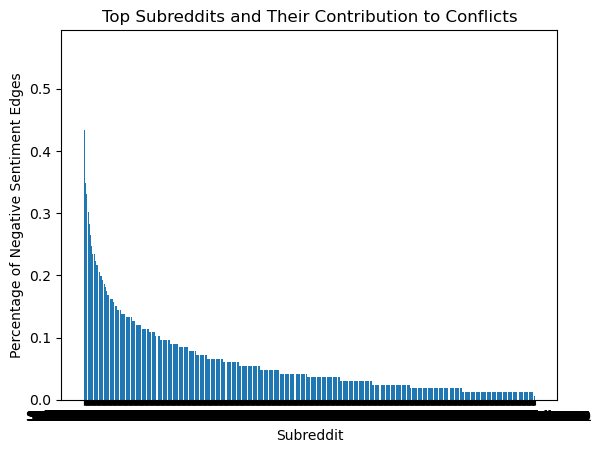

In [115]:
# Sort subreddits by percentage in descending order
sorted_subreddits = sorted(subreddit_percentages.items(), key=lambda x: x[1], reverse=True)

# Calculate cumulative percentage
cumulative_percentage = 0
top_subreddits = []
for subreddit, percentage in sorted_subreddits:
    cumulative_percentage += percentage
    top_subreddits.append((subreddit, percentage))
    if cumulative_percentage >= 75:
        break

# Print top subreddits and their contribution to conflicts
for subreddit, percentage in top_subreddits:
    print(f"Subreddit {subreddit}: Percentage of Negative Sentiment Edges {percentage}%")

# Visualize the result (you can choose a suitable visualization method)
plt.bar([f"Subreddit {subreddit}" for subreddit, _ in top_subreddits], [percentage for _, percentage in top_subreddits])
plt.xlabel('Subreddit')
plt.ylabel('Percentage of Negative Sentiment Edges')
plt.title('Top Subreddits and Their Contribution to Conflicts')
plt.show()

Subreddit 24733: Percentage of Negative Sentiment Edges 0.5659922928709056%
Subreddit 26984: Percentage of Negative Sentiment Edges 0.4335260115606936%
Subreddit 25088: Percentage of Negative Sentiment Edges 0.4034200385356455%
Subreddit 34910: Percentage of Negative Sentiment Edges 0.3793352601156069%
Subreddit 33656: Percentage of Negative Sentiment Edges 0.3492292870905588%
Subreddit 33687: Percentage of Negative Sentiment Edges 0.3492292870905588%
Subreddit 16451: Percentage of Negative Sentiment Edges 0.3432080924855491%
Subreddit 25206: Percentage of Negative Sentiment Edges 0.33116570327552985%
Subreddit 28559: Percentage of Negative Sentiment Edges 0.33116570327552985%
Subreddit 29224: Percentage of Negative Sentiment Edges 0.33116570327552985%
Subreddit 13920: Percentage of Negative Sentiment Edges 0.32514450867052025%
Subreddit 18556: Percentage of Negative Sentiment Edges 0.3131021194605009%
Subreddit 14751: Percentage of Negative Sentiment Edges 0.3010597302504817%
Subreddi

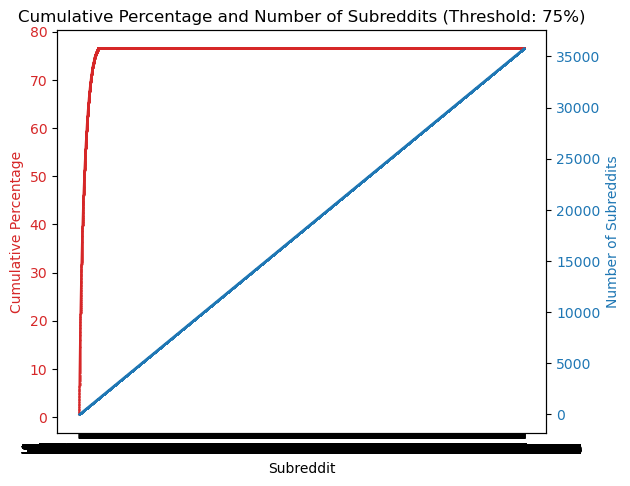

In [120]:
import matplotlib.pyplot as plt

# Sort subreddits by percentage in descending order
sorted_subreddits = sorted(subreddit_percentages.items(), key=lambda x: x[1], reverse=True)

# Calculate cumulative percentage and number of subreddits
cumulative_percentage = 0
top_subreddits = []
cumulative_percentages = []
selected_subreddits_count = 0
selected_subreddits_percentage = 0

# Specify the cumulative threshold (e.g., 75%)
cumulative_threshold = 75

for subreddit, percentage in sorted_subreddits:
    cumulative_percentage += percentage
    top_subreddits.append((subreddit, percentage))
    cumulative_percentages.append(cumulative_percentage)

    # Check if cumulative percentage exceeds the threshold
    if cumulative_percentage >= cumulative_threshold and selected_subreddits_count == 0:
        selected_subreddits_count = len(top_subreddits)
        selected_subreddits_percentage = cumulative_percentage

# Print top subreddits and their contribution to conflicts
for subreddit, percentage in top_subreddits:
    print(f"Subreddit {subreddit}: Percentage of Negative Sentiment Edges {percentage}%")

# Print information about selected subreddits
print(f"\nNumber of Subreddits Contributing to {cumulative_threshold}% of Negative Sentiment Edges: {selected_subreddits_count}")
print(f"Percentage of Total Nodes: {selected_subreddits_percentage}%")

# Calculate the percentage of nodes contributed by the top subreddits
total_nodes = G.GetNodes()
percentage_of_nodes = (selected_subreddits_count / total_nodes) * 100
print(f"\nPercentage of Total Nodes Contributed by Top Subreddits: {percentage_of_nodes}%")

# Visualize the result 
fig, ax1 = plt.subplots()

# Plot cumulative percentage
color = 'tab:red'
ax1.set_xlabel('Subreddit')
ax1.set_ylabel('Cumulative Percentage', color=color)
ax1.plot([f"Subreddit {subreddit}" for subreddit, _ in top_subreddits], cumulative_percentages, marker='o', markersize=0.5, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis to plot the number of subreddits
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Number of Subreddits', color=color)
ax2.plot([f"Subreddit {subreddit}" for subreddit, _ in top_subreddits], range(1, len(top_subreddits) + 1), marker='x', markersize=0.5, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(f'Cumulative Percentage and Number of Subreddits (Threshold: {cumulative_threshold}%)')
plt.xticks(rotation=90)
plt.show()
